In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices("GPU"))

2024-02-21 22:50:22.771767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 22:50:22.771827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 22:50:22.772645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 22:50:22.778330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 22:50:23.723692: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-21 22:50:24.702692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 22:50:24.730217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 22:50:24.730523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt


class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get("mean_absolute_error"))
        self.val_losses.append(logs.get("val_mean_absolute_error"))

        plt.clf()
        plt.plot(self.x, self.losses, label="mean_absolute_error")
        plt.plot(self.x, self.val_losses, label="val_mean_absolute_error")
        plt.legend()
        plt.pause(0.01)

In [4]:
import pandas as pd
import seaborn as sns

DATAPATH = "data"

df = pd.read_csv(f"{DATAPATH}/fried_noodles_dataset.csv")
df["c"] = 0b000  # meat, veggie, noodle
df

,filename,meat,veggie,noodle,c
0,0-food_tray-10-top.jpg,0,0,0,0
1,0-food_tray-12-top.jpg,0,0,0,0
2,0-food_tray-13-top.jpg,0,0,0,0
3,0-food_tray-14-top.jpg,0,0,0,0
4,0-food_tray-16-top.jpg,0,0,0,0
...,...,...,...,...,...
1851,2020_09_18-266-top.jpg,15,15,60,0
1852,2020_09_18-267-top.jpg,15,15,60,0
1853,2020_09_18-268-top.jpg,15,15,60,0
1854,2020_09_18-269-top.jpg,15,15,60,0


In [5]:
# NO MEAT, NO VEGGIE, NO NOODLE, MEAT, VEGGIE, NOODLE

df.loc[df["meat"] > 0, "c"] = df.loc[df["meat"] > 0, "c"] | 0b100
df.loc[df["veggie"] > 0, "c"] = df.loc[df["veggie"] > 0, "c"] | 0b010
df.loc[df["noodle"] > 0, "c"] = df.loc[df["noodle"] > 0, "c"] | 0b001

df

,filename,meat,veggie,noodle,c
0,0-food_tray-10-top.jpg,0,0,0,0
1,0-food_tray-12-top.jpg,0,0,0,0
2,0-food_tray-13-top.jpg,0,0,0,0
3,0-food_tray-14-top.jpg,0,0,0,0
4,0-food_tray-16-top.jpg,0,0,0,0
...,...,...,...,...,...
1851,2020_09_18-266-top.jpg,15,15,60,7
1852,2020_09_18-267-top.jpg,15,15,60,7
1853,2020_09_18-268-top.jpg,15,15,60,7
1854,2020_09_18-269-top.jpg,15,15,60,7


In [6]:
df["c"].value_counts()

c
7    891
2    254
3    247
1    158
4    129
6     96
5     57
0     24
Name: count, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(df, train_size=0.8)

In [8]:
train_set["c"].value_counts()

c
7    711
2    206
3    204
1    121
4    105
6     70
5     47
0     20
Name: count, dtype: int64

In [9]:
for i, r in train_set['c'].value_counts(normalize=True).items():
    print(i, r)

7 0.47911051212938005
2 0.13881401617250674
3 0.13746630727762804
1 0.08153638814016173
4 0.07075471698113207
6 0.04716981132075472
5 0.03167115902964959
0 0.013477088948787063


In [10]:
# can we make more dynamic ??
a = pd.concat([train_set[train_set["c"] == 0].copy()] * 6, ignore_index=True)
b = pd.concat([train_set[train_set["c"] == 5].copy()] * 5, ignore_index=True)
c = pd.concat([train_set[train_set["c"] == 6].copy()] * 2, ignore_index=True)
d = pd.concat([train_set[train_set["c"] == 4].copy()] * 2, ignore_index=True)
e = pd.concat([train_set[train_set["c"] == 1].copy()] * 2, ignore_index=True)

#train_set = pd.concat([train_set, a, b, c, d, e], ignore_index=True)
# new_train_set['c'].value_counts()
train_set["c"].value_counts()

c
7    711
2    206
3    204
1    121
4    105
6     70
5     47
0     20
Name: count, dtype: int64

In [11]:
validation_set["c"].value_counts()

c
7    180
2     48
3     43
1     37
6     26
4     24
5     10
0      4
Name: count, dtype: int64

In [12]:
# COPY THE ROW ON TRAINING SET, TO MAKE THE NETWORK SEE THE SAME DISTRIBUTION OF
# WE NEED TO DEFINE SOME CLASS NO_MEAT

selected_rows = (train_set[train_set["meat"] > 20]).copy()
selected_rows = pd.concat(
    [selected_rows, selected_rows, selected_rows, selected_rows], ignore_index=True
)

# train_set = pd.concat([train_set, selected_rows], ignore_index=True)
# selected_rows
train_set["meat"].mean()

7.248652291105121

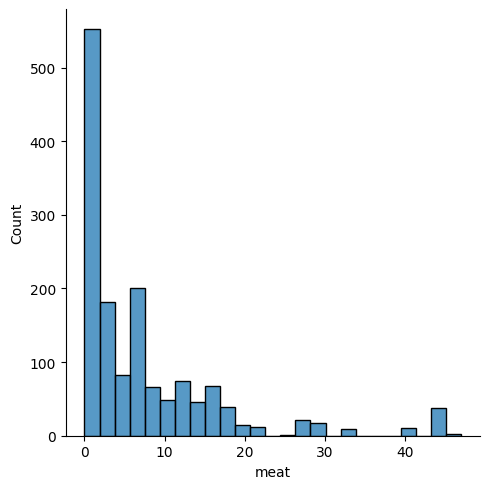

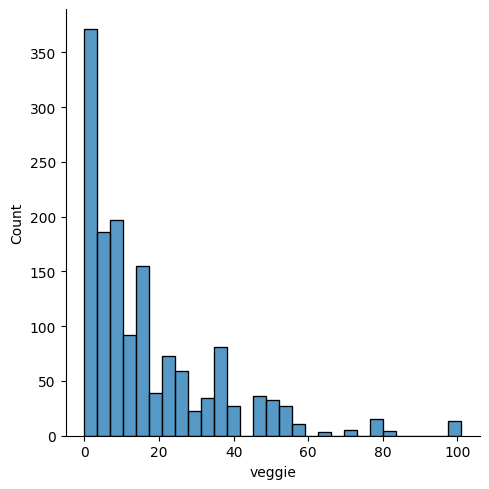

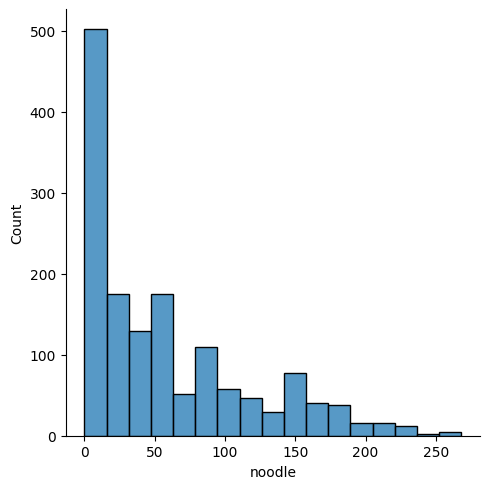

In [13]:
import seaborn as sns

sns.displot(train_set, x="meat")
sns.displot(train_set, x="veggie")
sns.displot(train_set, x="noodle")

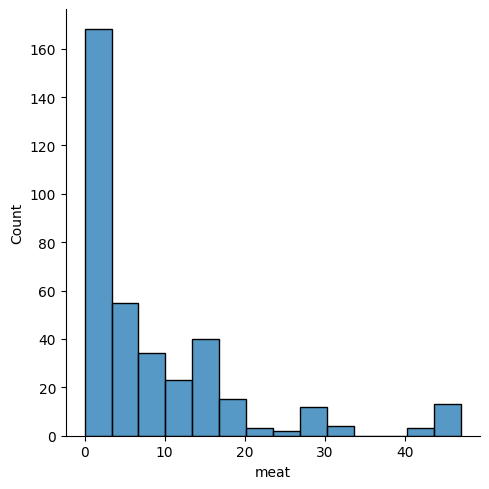

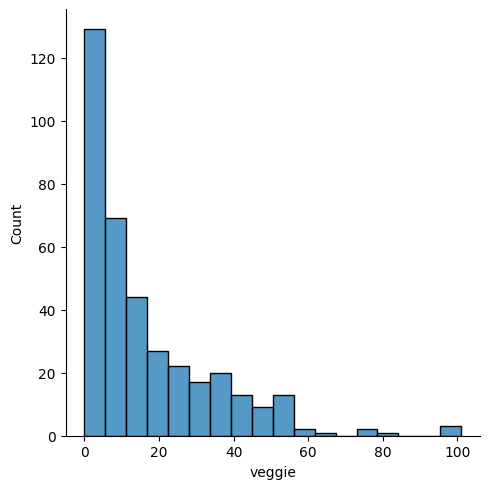

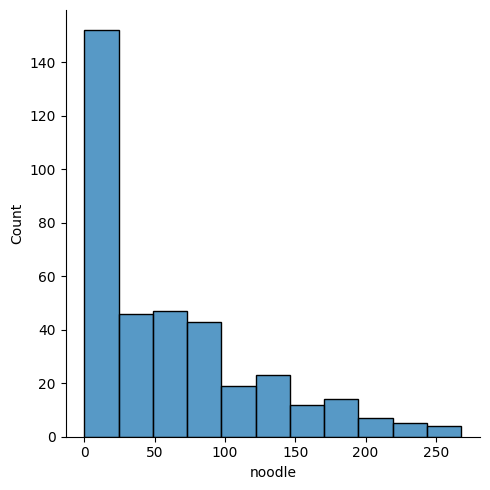

In [14]:
sns.displot(validation_set, x="meat")
sns.displot(validation_set, x="veggie")
sns.displot(validation_set, x="noodle")

ref1: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
ref2: https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow
and mucmore

prepare data, 


1. read train_set
2. use ImageGenerator to preprocess the image
4. train the model using the result from the image
5. evaluate on validation_set

In [15]:
from keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

img_size = (350, 550)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    target_size=(img_size[0], img_size[1]),
)

test_dategen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = train_datagen.flow_from_dataframe(
    validation_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    shuffle=False,
    target_size=(img_size[0], img_size[1]),
)

Found 1484 validated image filenames.
Found 372 validated image filenames.


In [16]:
import keras
from keras.models import Model
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    BatchNormalization,
    Conv2D,
    MaxPool2D,
)
from keras.optimizers import Adam
"""
base_model = keras.applications.ResNet50(
    weights="imagenet", input_shape=(img_size[0], img_size[1], 3), include_top=False
)
base_model.trainable = False

input = Input(
    shape=(
        img_size[0],
        img_size[1],
        3,
    )
)
x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
dense = Dense(512, activation='sigmoid')(x)
dense = Dense(256, activation='sigmoid')(dense)
dense = Dense(128, activation='sigmoid')(dense)
output = keras.layers.Dense(3)(dense)

model = Model(inputs=input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4), loss="mse", metrics="mean_absolute_error"
)
model.summary(show_trainable=True)
"""

'\nbase_model = keras.applications.ResNet50(\n    weights="imagenet", input_shape=(img_size[0], img_size[1], 3), include_top=False\n)\nbase_model.trainable = False\n\ninput = Input(\n    shape=(\n        img_size[0],\n        img_size[1],\n        3,\n    )\n)\nx = base_model(input, training=False)\nx = keras.layers.GlobalAveragePooling2D()(x)\ndense = Dense(512, activation=\'sigmoid\')(x)\ndense = Dense(256, activation=\'sigmoid\')(dense)\ndense = Dense(128, activation=\'sigmoid\')(dense)\noutput = keras.layers.Dense(3)(dense)\n\nmodel = Model(inputs=input, outputs=output)\n\nmodel.compile(\n    optimizer=Adam(learning_rate=1e-4), loss="mse", metrics="mean_absolute_error"\n)\nmodel.summary(show_trainable=True)\n'

In [17]:

inputIm = Input(shape = (img_size[0], img_size[1],3,))
conv1 = Conv2D(64,3,activation='relu')(inputIm)
conv1 = Conv2D(64,3,activation='relu')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPool2D()(conv1)
conv2 = Conv2D(128,3,activation='relu')(pool1)
conv2 = Conv2D(128,3,activation='relu')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPool2D()(conv2)
conv3 = Conv2D(256,3,activation='relu')(pool2)
conv3 = Conv2D(256,3,activation='relu')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPool2D()(conv3)
conv4 = Conv2D(512,3,activation='relu')(pool3)
conv4 = Conv2D(512,3,activation='relu')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPool2D()(conv4)

flat = Flatten()(pool4)
dense1 = Dense(512,activation='sigmoid')(flat)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512,activation='sigmoid')(dense1)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512,activation='sigmoid')(dense1)
dense1 = Dropout(0.5)(dense1)
predictedW = Dense(3)(dense1)

model = Model(inputs=inputIm, outputs=predictedW)

model.compile(optimizer=Adam(learning_rate = 1e-4), loss='mse', metrics=['mean_absolute_error'])
#model.summary(show_trainable=True)

2024-02-21 22:50:27.128790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 22:50:27.129038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 22:50:27.129226: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 22:50:27.253914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 22:50:27.254162: I external/local_xla/xla/stream_executor

In [18]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "temp.keras",
    verbose=1,
    monitor="val_mean_absolute_error",
    save_best_only=True,
    mode="min",
)
plot_losses = PlotLosses()

In [19]:
# Train the Model
train_generator.reset()
model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, plot_losses],
)

Epoch 1/20


2024-02-21 22:50:37.157391: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-21 22:50:42.633692: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f39a82f5a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 22:50:42.633728: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-02-21 22:50:42.638981: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708530642.714859   16933 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-21 22:50:59.140641: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller

 9/47 [====>.........................] - ETA: 21s - loss: 2478.0344 - mean_absolute_error: 25.5013

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
from keras.models import load_model

# Test Model
model = load_model("best.keras")
"""
score = model.evaluate(x=validation_generator, steps=len(validation_generator))
print("score (mse, mae):\n", score)
"""
model.summary()

In [ ]:
validation_generator.reset()
predict = model.predict(
    x=validation_generator,
    steps=len(validation_generator),
    workers=1,
    use_multiprocessing=False,
)
print("prediction:\n", predict)

In [ ]:
val_set = validation_set.copy()

val_set["meat"] = predict[:, 0]
val_set["veggie"] = predict[:, 1]
val_set["noodle"] = predict[:, 2]

val_set.compare(validation_set)

In [ ]:
sns.displot(val_set, x="meat")
sns.displot(val_set, x="veggie")
sns.displot(val_set, x="noodle")

In [ ]:
(val_set["meat"] - validation_set["meat"]).abs().mean()

In [ ]:
(val_set["veggie"] - validation_set["veggie"]).abs().mean()

In [ ]:
(val_set["noodle"] - validation_set["noodle"]).abs().mean()